# Load the important libraries

In [ ]:
!pip install transformers
!pip install rouge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.2 MB/s eta 0:00:00


In [ ]:
import json # for dealing with Json files
import pandas as pd # for dealing with dataset
import csv # used to wirte the data in CVS file
import matplotlib.pyplot as plt # make visualization
import seaborn as sns # make visualization

import torch # to import cuda.is_available() method to run on GPU
from transformers import AutoModelForSeq2SeqLM, AutoModelForSequenceClassification, AutoModel, AutoTokenizer, AdamW, pipeline

from rouge import Rouge # To import ROUGE metrics for evaluation

# 🔍 Step 1: Load dataset

Convert Json data to CVS file

In [ ]:
# The pass to the Json dataset (old)
input_file = 'labeled_validation_dataset.jsonl'
# The pass to the CSV dataset (new)
output_file = 'labeled_validation_dataset.csv'

# Read from the Json file and write in the CSV file
with open(input_file, 'r', encoding='utf-8') as input, open(output_file, 'w', encoding='utf-8', newline='') as output:
    # Write the rows in csv
    writer = csv.writer(output)
    # Create column names
    writer.writerow(['paragraph', 'summary'])

    # Loop on the input file and copy his content into output file
    for line in input:
        # Load the lines from Json data
        data = json.loads(line)
        # Copy the data
        paragraph = data['paragraph']
        summary = data['summary']

        # Write the extracted data to the output file
        writer.writerow([paragraph, summary])


load csv file

In [ ]:
# Read the new dataset that we was created in the above
dataset = pd.read_csv('labeled_validation_dataset.csv')
# display the dataset
dataset.head()

,paragraph,summary
0,وتحت عنوان من الكارثة إلى التحدى يبدأ الكاتب ع...,يبدأ الكاتب عرض الكتاب الرابع تحت عنوان من الك...
1,ولم يعترف دبلوماسيو هاتين الدولتين بالعريضة ال...,دبلوماسيو الدولتين لم يعترفوا بالعريضة التي قا...
2,قامت ولاية حلب بعد اعلان الجنرال الفرنسي هنري ...,أعلن غورو الانتداب الفرنسي على سوريا لكي يعاقب...
3,دولة مصر العربيه هي ليست اي دوله وليست اي شعب ...,مصر هي أم البلاد، وقائدة العرب؛ فهي أرض بلاد ا...
4,السوريون يصرون على استقلال بلادهم : و مثلما رف...,الشعب السوري يصر على استقلال بلدهم من السيطرة ...


# 📑 Step 2: Exploratory Data Analysis (EDA)

Not now..

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paragraph  154 non-null    object
 1   summary    154 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


In [ ]:
dataset.shape

(154, 2)

### Number of tokens in a text
> split text to tokens

    - applies the split() method to each element in the 'text' column.
    - It splits the text into a list of tokens,

> mapping lambda function

    - applies the map() method for each token in the text,
    - it calculates the length of the token using len(i)

> final result

    - dataset_train['no_tokens']= stores the lengths of the words for each text.

In [ ]:
dataset['tokens_paragraph']= dataset['paragraph'].str.split().map(lambda token: len(token))
dataset.sample(10)

,paragraph,summary,tokens_paragraph
134,عقب تأميم القناة والعدوان الثلاثي خاضت الحكومة...,بعد العدوان الثلاثي دخلت مصر مفاوضات مع ادارة ...,342
143,وحكم الأتراك مصر على الطريقة التي حكمتها بها ر...,الأتراك حكموا مصر مثل روما،ونقلوا الخليفة العب...,370
31,ويقول د . ماهر عبد القادر وكيل الكلية ورئيس تح...,بنى مدينة الإسكندرية الإسكندر الأكبر ثم البطال...,329
126,في يوم 28 فبراير عام 1922 م عاد اللورد أدموند ...,اللورد أدموند عاد ومعه تصاريح وتشمل إعلان إنها...,376
19,جبيل .. مدينة الحرف وقبلة السياح تعتبر مدينة ج...,تاريخ من العراقة وحكاية من العمران مازالت فصول...,351
93,فلما ملك المستنصر سنة 427 ه أصبح الجند طائفتين...,عندما تولى المستنصر الحكم أصبح الجند طائفتين، ...,385
8,وكان للبطل محمد علي فهمي بعض العمليات الهامة ق...,كان للبطل محمد علي فهمي بعض العمليات المهمة ال...,374
104,ومن الحضارات التي ازدهرت في شبه الجزيرة ، حضار...,حضار قوم عاد من أقدم الحضارات التي ازدهرت في ش...,321
54,دخلت بلاد فارس تاريخ الشرق الأوسط من الباب الو...,قورش العظيم مؤسس الدولة الأخمينية ( الفارسية )...,361
38,ثم عاد الزعيم عمر مكرم إلى القاهرة وتظاهر بالا...,عاد مكرم مُظهرا الاعتزال للفرنسيين وكان يخطط م...,292


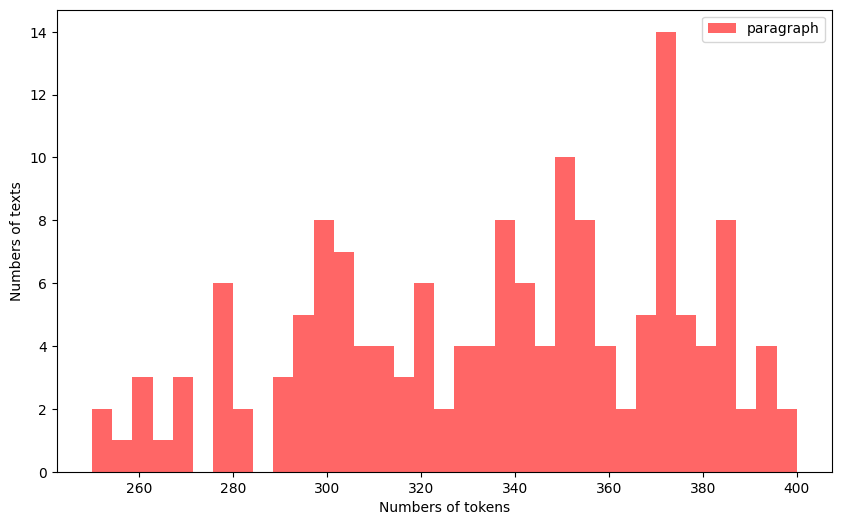

In [ ]:
plt.figure(figsize=(10, 6))

dataset['tokens_paragraph'].plot(bins=35,
                            kind='hist',
                            color='red',
                            label='paragraph',
                            alpha=0.6)

plt.legend(loc='upper right')
plt.xlabel("Numbers of tokens")
plt.ylabel("Numbers of texts")
plt.show()

max tokens

In [ ]:
max_tokens= dataset['tokens_paragraph'].max()
max_tokens

400

show max tokens

In [ ]:
dataset[dataset['tokens_paragraph'] == max_tokens]['paragraph']

116    وبعد أن قامت حكومة الوفد بإلغاء معاهدة عام 193...
Name: paragraph, dtype: object

# Step 3: Load the Pretrained Transformer Model (mT5) on GPU

In [ ]:
# model_name = "arabert/arb-summarization-pegasus"
# model_name = "facebook/bart-large"
# model_name = "asafaya/bert-base-arabic-t5"

# define pretrained model on GPU
model_name= "eslamxm/mt5-base-arabic"
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# pass first parameter is 'summarization' for abstractive text summarization.
# model = pipeline("summarization", model=model_name, tokenizer=model_name, device=device)

# Step 4: Fine-tuning the model

Fine-tuning the *model*

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5)
model.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


MT5ForConditionalGeneration(
  (shared): Embedding(250112, 768)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
         

Prepare the training data

In [ ]:
train_data = dataset[:100]  # Adjust the number of training examples as per your dataset size
train_encodings = tokenizer(train_data['paragraph'].tolist(), truncation=True, padding=True, max_length=512, return_tensors='pt')
train_labels = tokenizer(train_data['summary'].tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')

In [ ]:
train_dataset = torch.utils.data.TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, train_labels.input_ids, train_labels.attention_mask)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

In [ ]:
epochs = 3  # Adjust the number of epochs as per your preference

for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels, labels_attention_mask = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        labels_attention_mask = labels_attention_mask.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels, decoder_attention_mask=labels_attention_mask)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}: Average Loss = {average_loss}")

In [ ]:
epochs = 3  # Adjust the number of epochs as per your preference
accumulation_steps = 4  # Number of steps to accumulate gradients before performing an update
total_loss = 0
steps = 0

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels, labels_attention_mask = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        labels_attention_mask = labels_attention_mask.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels, decoder_attention_mask=labels_attention_mask)
        loss = outputs.loss

        loss = loss / accumulation_steps  # Scale the loss by the number of accumulation steps

        loss.backward()

        total_loss += loss.item()

        steps += 1
        if steps % accumulation_steps == 0:
            optimizer.step()  # Perform parameter update every accumulation_steps

            # Print average loss every accumulation_steps
            average_loss = total_loss / accumulation_steps
            print(f"Epoch {epoch + 1}/{epochs}, Step {steps}: Average Loss = {average_loss}")

            total_loss = 0

    # Perform a final update if there are remaining accumulated gradients
    if steps % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    # Print average loss at the end of each epoch
    average_loss = total_loss / accumulation_steps
    print(f"Epoch {epoch + 1}/{epochs}: Average Loss = {average_loss}")


# Step 5: Tokenization and get generated summaries or hypotheses on GPU

In [ ]:
generated_summaries = []

for index, row in dataset.iterrows():
    input_text = row['paragraph']
    # encoding step
    input_tokens = tokenizer.encode(input_text, truncation=True, padding=True, return_tensors="pt").to(device)
    # generation step
    summary_ids = model.generate(input_tokens, num_beams=4, max_length=300, early_stopping=True)
    # decoding step
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # we can replace 3 steps with one step pipeline
    # summary = model(input_text, max_length=100, num_beams=4, early_stopping=True)[0]['summary_text']
    '''
    + Encoding:
    - Pipeline automatically handles the encoding of the input text using the specified tokenizer associated with the model.
    + Generation:
    - Handles the generation of the summary by specifying the 'max_length', 'num_beams', and 'early_stopping' parameters.
    + Decoding:
    - Extract index 0 which is generated summary from the pipeline's output, which is a dictionary.
    '''
    generated_summaries.append(summary)

Add the column generated summaries or hypotheses to the dataset

In [ ]:
dataset['generated_summary'] = generated_summaries

Print the updated dataset with generated summaries

In [ ]:
dataset.head()

# Step 6: Evaluation using ROUGE metrics
+ ROUGE: (Recall-Oriented Understudy for Gisting Evaluation)
+ used for evaluating the quality of text summarization outputs.

Initialize object from ROUGE metric

In [ ]:
rouge = Rouge()

+ Prepare the references and hypotheses:
  - column [summary] is references..
      - Convert the reference summaries from the dataset into a list
  - column [generated_summary] is hypotheses..
      - Convert the generated summaries into a list

In [ ]:
references = dataset['summary'].tolist()
hypotheses = dataset['generated_summary'].tolist()

- Pass hypotheses and references for method get_scores to compute the ROUGE scores:
- avg= True >> compute average scores for all the scores.

In [ ]:
scores = rouge.get_scores(hypotheses, references, avg=True)

- ROUGE-1: measures the overlap of `unigrams (single words)` between the generated summary (hypotheses) and the reference summary.

- ROUGE-2: measures the overlap of `bigrams (pairs of consecutive words)` between the generated summary (hypotheses) and the reference summary.

- ROUGE-L: measures the `longest common subsequence (LCS)` between the generated summary (hypotheses) and the reference summary.

- Precision: ratio of the number of overlapping unigrams (ROUGE-1), bigrams (ROUGE-2) or LCS (ROUGE-L) between the generated and reference summaries to the number of unigrams or bigrams or LCS in the `generated summary`.

- Recall: ratio of the number of overlapping unigrams (ROUGE-1), bigrams (ROUGE-2) or LCS (ROUGE-L) between the generated and reference summaries to the number of unigrams or bigrams or LCS in the `reference summary`.

- ROUGE-1 Score: `harmonic mean` of precision and recall.

In [ ]:
print("ROUGE-1: ", scores['rouge-1'])
print("ROUGE-2: ", scores['rouge-2'])
print("ROUGE-L: ", scores['rouge-l'])
print("Precision: ", scores['rouge-1']['p'])
print("Recall: ", scores['rouge-1']['r'])
print("ROUGE-1 Score: ", scores['rouge-1']['f'])

# Step 7: Save the model

In [ ]:
model.save_pretrained("AS_mT5")

# Step 8: Load the fine-tuned model for inference (Predict)

In [ ]:
load_model= r'AS_mT5'
fine_tuned_model = AutoModelForSeq2SeqLM.from_pretrained(load_model)
tokenizer = AutoTokenizer.from_pretrained(load_model)
summarizer = pipeline("summarization", model=fine_tuned_model, tokenizer=tokenizer)

Test example

In [ ]:
input_text = "لم يعترف دبلوماسيو هاتين الدولتين بالعريضة التي وقعها الأعيان ، إذ اعتبروها محاولة فقط من سلطات الحماية لإجبار السلطان على قبول مخططاتها وذلك بالتوقيع على الظهائر . أما معارضة الدول العربية والآسيوية ، فإنها تمثلت في شنها لحملة شرسة عبر الصحافة والإذاعة ضد الإجراء الفرنسي . فما إن أعلن عن نبأ تنحية السلطان حتى أدان زعيم الحركة الوطنية علال الفاسي عبر إذاعة القاهرة في برنامج صوت العرب إبعاد السلطان هو وعائلته عن الوطن . وأما جامعة الدول العربية ، فقد عبرت عن تخوفاتها إزاء تطورات القضية المغربية وبدأت في الإلحاح على ضرورة استقلال المغرب . ومنذ 21 أغسطس 1953، أظهرت 15 دولة عربية آسيوية عضو في هيئة الأمم المتحدة انشغالها بمستقبل الاستقرار السياسي بشمال إفريقيا بعد عملية نفي محمد بن يوسف . وعلى مستوى العلاقات السياسية بين فرنسا وإسبانيا ، حدث الأمر نفسه . فحسب الوفق الذي أبرم بين البلدين يوم 27 نوفمبر 1912، فقد حدد أنه يتعهد البلدان بالتزام \" الاحترام إزاء الإمبراطورية الشريفة \"، في المنطقتين ، الخليفية التابعة للحماية الإسبانية ، والجنوبية ، الخاضعة للحماية الفرنسية . وقد استقبلت عملية تنصيب سلطان جديد على المغرب بإسبانيا بنوع من الاستياء ، إذ اعتبرته سلطات مدريد إعلانا لنوع من العداء ضدها . مما دفعها إلى تنظيم عملية توقيع عريضة مشابهة لتلك التي تمت بمراكش في المنطقة التي تخضع لسيطرتها . وتمكنت من جمع 430 توقيعا من باشوات وأعيان المنطقة الخليفية ركزت فيها على تثبيت فكرة \" تنحية السلطان الشرعي محمد بن يوسف ، نتيجة للدسائس التي حاكتها الإقامة العامة \" ورفض \" سلطة ابن عرفة .. والتي فرضتها فرنسا ضد إرادة الشعب المغربي \". ثم أعلنت العريضة \" أحقية السيادة التي يتمتع بها المهدي بن إسماعيل على المنطقة الخليفية \"، وذلك تحت إمرة سلطة فرانكو ."

In [ ]:
summary_text = summarizer(input_text, max_length=128, min_length=30, do_sample=False, early_stopping=True)[0]['summary_text']

Result

In [ ]:
print(f"Summary: {summary_text}")